/Users/omerhacohen/ws/pixel-brain/venv/lib/python3.8/site-packages/pinecone/data/index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/Users/omerhacohen/ws/pixel-brain/venv/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [19:00:23] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Testing RMSE: 0.6900682163966552
Testing AUC: 0.5
FPR: [0. 1.], TPR: [0. 1.], Thresholds: [inf  0.]


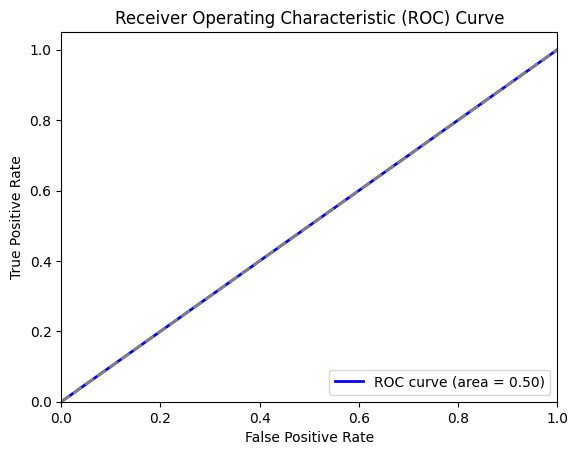

In [1]:
from pixelbrain.database_processors.xgboost_processor import XGBoostDatabaseRegressorTrainer, XGBoostDatabaseProcessor
from pixelbrain.database import Database
import os
import numpy as np

mongo_key=os.getenv("MONGO_URL")
db = Database(database_id="Selfyx", mongo_key=mongo_key)

data_field_names = [
    "cfg_scale",
    "pick_score",
    "similarity_score_nearest",
    "similarity_score_average_k_nearest",
    "similarity_score_maximum_distance",
    "generated_epoch"
]

metric_field_name = "human_rating"
trainer = XGBoostDatabaseRegressorTrainer(db, data_field_names, metric_field_name)
rmse, auc = trainer.fit(save_model_path="xgboost_rating_model.pkl", auc_threshold=4, plot_auc_curve=True)



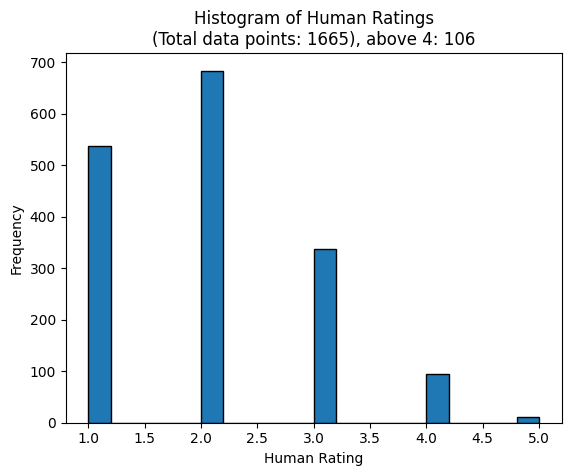

In [2]:
import matplotlib.pyplot as plt
import numpy as np
# Fetch the data from the database
field_names = data_field_names + [metric_field_name]
filters = {field_name: None for field_name in field_names}
labeld_data = db.find_images_with_filters(filters)

# Extract the metric values
metric_values = np.array([record[metric_field_name] for record in labeld_data])
nof_metrics_more_then_4 = np.sum(np.where(metric_values >= 4, 1, 0))
# Plot the histogram
plt.hist(metric_values, bins=20, edgecolor='black')
plt.title(f'Histogram of Human Ratings\n(Total data points: {len(metric_values)}), above 4: {nof_metrics_more_then_4}')
plt.xlabel('Human Rating')
plt.ylabel('Frequency')
plt.show()



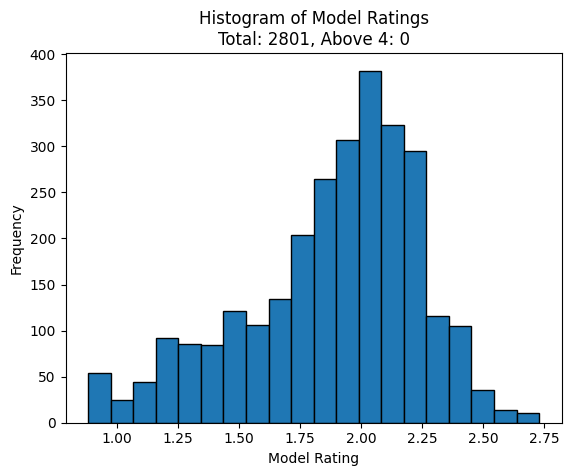

In [3]:
predictor = XGBoostDatabaseProcessor(db, data_field_names, model_path="xgboost_rating_model.pkl")

def plot_predictor_histogram(predictor):
    prep_data = predictor.get_prepared_data()
    predictions = predictor.predict(prep_data)

    # Calculate the total number of datapoints and the number of datapoints above 4 rating
    total_datapoints = len(predictions)
    datapoints_above_4 = np.sum(predictions >= 4)

    # Plot the histogram
    plt.hist(predictions, bins=20, edgecolor='black')
    plt.title(f'Histogram of Model Ratings\nTotal: {total_datapoints}, Above 4: {datapoints_above_4}')
    plt.xlabel('Model Rating')
    plt.ylabel('Frequency')
    plt.show()

plot_predictor_histogram(predictor)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Testing RMSE: 0.7730846772307219
Testing AUC: 0.5
FPR: [0. 1.], TPR: [0. 1.], Thresholds: [inf  0.]


/Users/omerhacohen/ws/pixel-brain/venv/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [19:19:32] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


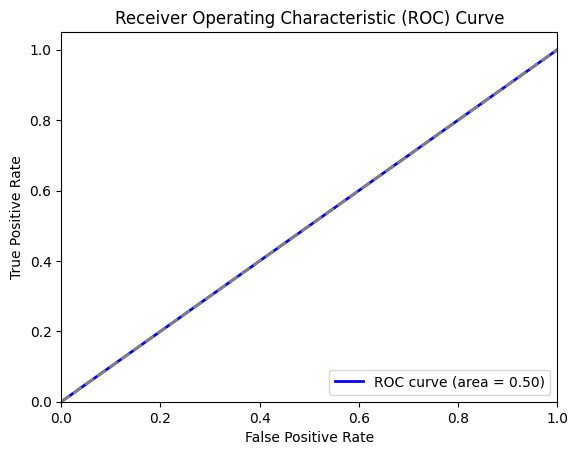

In [37]:
def mse_weights(y_true):
    weights = np.where(y_true >= 3, 10, 1)
    weights = np.where(y_true >= 4, 1000, weights)
    return weights

trainer_new_metric = XGBoostDatabaseRegressorTrainer(db, data_field_names, metric_field_name, mse_weights_func=mse_weights)
rmse, auc = trainer_new_metric.fit(save_model_path="xgboost_rating_model_new_metric.pkl", auc_threshold=4, plot_auc_curve=True)



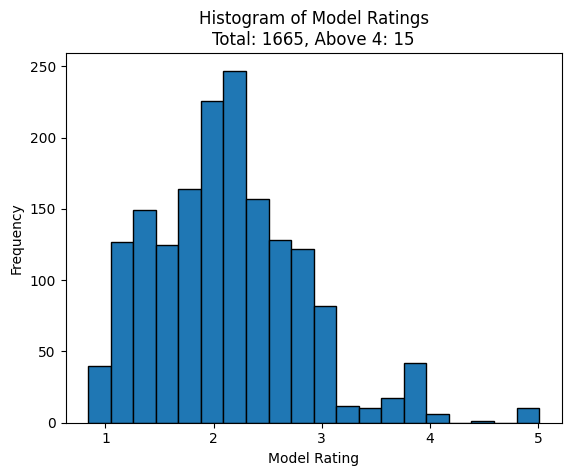

In [38]:
new_predictor = XGBoostDatabaseProcessor(db, data_field_names, model_path="xgboost_rating_model_new_metric.pkl", filters={metric_field_name: None})
plot_predictor_histogram(new_predictor)


In [39]:
import pandas as pd

labeld_data_df = pd.DataFrame(labeld_data)
labeld_data_to_predict = labeld_data_df[data_field_names]
metric_to_predict = labeld_data_df[metric_field_name]

print(labeld_data_to_predict)

      cfg_scale  pick_score  similarity_score_nearest  \
0           6.0   19.112318                 10.883402   
1           6.0   19.529348                 10.886930   
2           6.0   19.372534                 11.901322   
3           6.0   19.584103                 12.438620   
4           6.0   19.219236                 10.084253   
...         ...         ...                       ...   
1660       12.0   19.562531                 11.797161   
1661       12.0   19.498915                 13.696759   
1662       12.0   19.228992                 12.558798   
1663       12.0   19.345488                 10.705823   
1664       12.0   18.660030                 13.054452   

      similarity_score_average_k_nearest  similarity_score_maximum_distance  \
0                               8.664208                          16.783709   
1                              10.785277                          17.518455   
2                              10.567776                          18.091351   

In [40]:
predictions = new_predictor.predict(labeld_data_to_predict)
filtered_indices = (metric_to_predict >= 4)

filtered_predictions = predictions[filtered_indices]
filtered_metric_to_predict = metric_to_predict[filtered_indices]

for actual, predicted in zip(filtered_metric_to_predict, filtered_predictions):
    print(f"Actual: {actual}, Predicted: {predicted}")



Actual: 4, Predicted: 3.8317360877990723
Actual: 4, Predicted: 3.8602347373962402
Actual: 4, Predicted: 2.964162826538086
Actual: 4, Predicted: 3.6897239685058594
Actual: 4, Predicted: 3.821911573410034
Actual: 4, Predicted: 2.9630327224731445
Actual: 4, Predicted: 3.550025701522827
Actual: 4, Predicted: 4.018599510192871
Actual: 4, Predicted: 3.770435333251953
Actual: 4, Predicted: 4.007853984832764
Actual: 4, Predicted: 3.683011770248413
Actual: 4, Predicted: 3.8347535133361816
Actual: 4, Predicted: 3.54789662361145
Actual: 4, Predicted: 3.789560317993164
Actual: 4, Predicted: 3.6300036907196045
Actual: 4, Predicted: 2.9612996578216553
Actual: 4, Predicted: 3.4086215496063232
Actual: 4, Predicted: 2.949719190597534
Actual: 4, Predicted: 3.7413082122802734
Actual: 4, Predicted: 3.729978084564209
Actual: 4, Predicted: 3.7924461364746094
Actual: 4, Predicted: 3.8081390857696533
Actual: 4, Predicted: 3.856872081756592
Actual: 4, Predicted: 3.9181923866271973
Actual: 4, Predicted: 4.00745

In [41]:
# Count the number of indices where both the metric and the prediction is above 4
good_above_4_indices = (metric_to_predict >= 4) & (predictions >= 4)
num_both_above_4 = sum(good_above_4_indices)

print(f"Number of indices where both the metric and the prediction is above 4: {num_both_above_4}")
for gt, pred in zip(metric_to_predict[good_above_4_indices], predictions[good_above_4_indices]):
    print(f"Actual: {gt}, Predicted: {pred}")



Number of indices where both the metric and the prediction is above 4: 15
Actual: 4, Predicted: 4.018599510192871
Actual: 4, Predicted: 4.007853984832764
Actual: 4, Predicted: 4.007453441619873
Actual: 5, Predicted: 4.567098617553711
Actual: 5, Predicted: 5.009551048278809
Actual: 5, Predicted: 4.899270057678223
Actual: 5, Predicted: 4.982484340667725
Actual: 5, Predicted: 4.9072699546813965
Actual: 5, Predicted: 4.941599369049072
Actual: 5, Predicted: 4.956960201263428
Actual: 5, Predicted: 4.971626281738281
Actual: 5, Predicted: 4.945807456970215
Actual: 5, Predicted: 4.97367000579834
Actual: 4, Predicted: 4.001021385192871
Actual: 5, Predicted: 4.987795352935791
